In this notebook, we aim to recognize the main entrance gates of several universities in Iran. In this regard, we collect a few images of gates of five Universities, including "Tehran, Amirkabir, Elm_o_Sanat, Ferdosi, Tarbiat_Modarres" and train VGG16-places365 model upper layers again for our dataset. Also, we use data augmentation to reduce overfitting. It is just homework for practicing transfer learning in Tensorflow Keras, and we do not try to get high accuracy. We could get 0.92 validation accuracy.

In [1]:
import os
from urllib.request import urlopen
import numpy as np
from PIL import Image
from cv2 import resize

from vgg16_places_365 import VGG16_Places365


Using TensorFlow backend.
C:\Users\Paniz\Anaconda3\envs\Tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Paniz\Anaconda3\envs\Tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Paniz\Anaconda3\envs\Tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Paniz\Anaconda3\envs\Te

In [2]:
base_model = VGG16_Places365(include_top=False, weights='places', input_shape=(150, 150, 3))
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
# making 12 last layers *Unfreeze*
for layer in base_model.layers[:12]:
  layer.trainable = True
for layer in base_model.layers[12:]:
  layer.trainable = False

In [4]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16-places365 (Model)      (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 5,014,341
Non-trainable params: 11,799,040
_________________________________________________________________


In [6]:
curr_dir = os.path.realpath('.')
base_dir = os.path.join(curr_dir, 'dataset/unis')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [7]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')


Found 182 images belonging to 5 classes.
Found 78 images belonging to 5 classes.


In [8]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [9]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,
      epochs=40,
      validation_data=test_generator,
      validation_steps=5)

Epoch 1/40
10/10 [==============================] - 52s 5s/step - loss: 1.9739 - acc: 0.1736 - val_loss: 1.7252 - val_acc: 0.3169
Epoch 2/40
10/10 [==============================] - 27s 3s/step - loss: 1.7411 - acc: 0.3551 - val_loss: 1.6614 - val_acc: 0.4274
Epoch 3/40
10/10 [==============================] - 28s 3s/step - loss: 1.5570 - acc: 0.4634 - val_loss: 1.2507 - val_acc: 0.6290
Epoch 4/40
10/10 [==============================] - 31s 3s/step - loss: 1.2326 - acc: 0.5764 - val_loss: 0.9793 - val_acc: 0.7535
Epoch 5/40
10/10 [==============================] - 32s 3s/step - loss: 1.0572 - acc: 0.7280 - val_loss: 0.7001 - val_acc: 0.8548
Epoch 6/40
10/10 [==============================] - 36s 4s/step - loss: 0.9762 - acc: 0.7070 - val_loss: 0.6372 - val_acc: 0.8710
Epoch 7/40
10/10 [==============================] - 36s 4s/step - loss: 0.8110 - acc: 0.7966 - val_loss: 0.5958 - val_acc: 0.8873
Epoch 8/40
10/10 [==============================] - 38s 4s/step - loss: 0.6824 - acc: 0.86

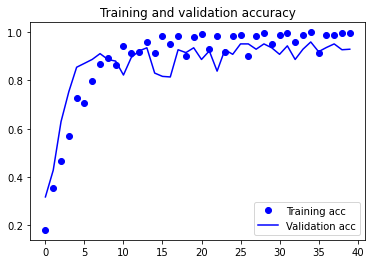

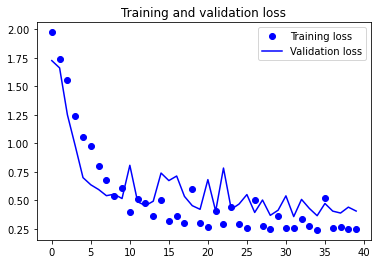

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

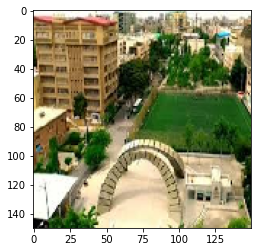

Amirkabir


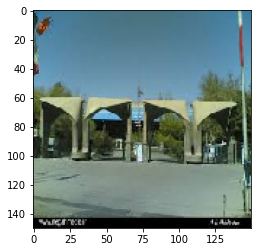

Tehran


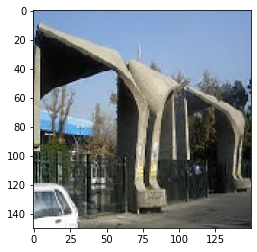

Tehran


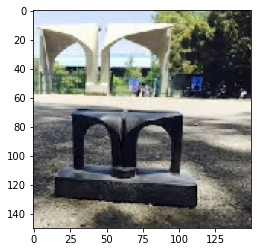

Tehran


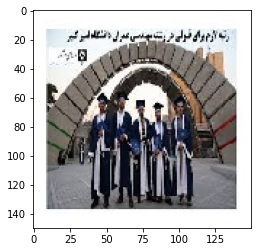

Amirkabir


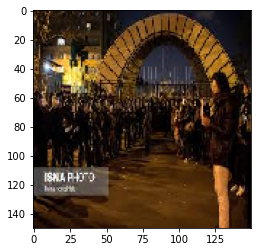

Amirkabir


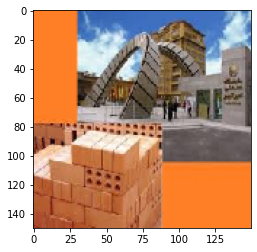

Amirkabir


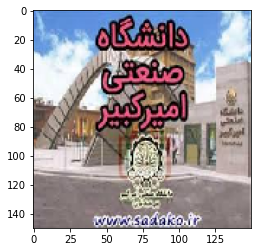

Amirkabir


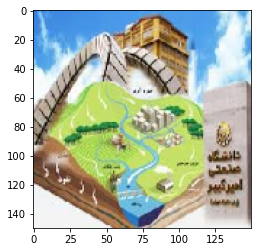

Amirkabir


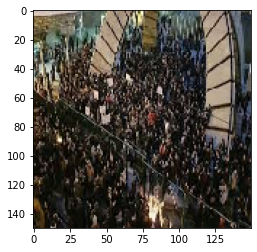

Amirkabir


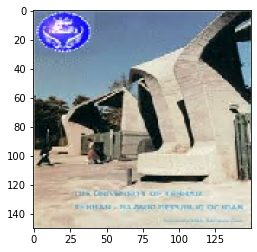

Ferdosi


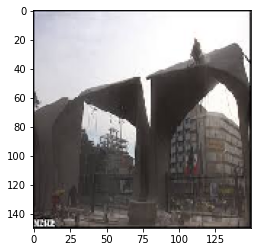

Tehran


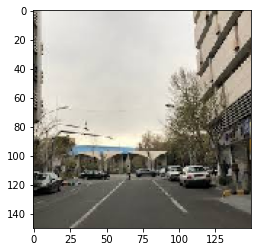

Elm_o_Sanat


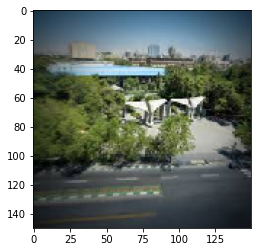

Amirkabir


In [39]:
from keras.preprocessing import image

label_map = (train_generator.class_indices)
labels = ["Amirkabir", "Elm_o_Sanat", "Ferdosi", "Tarbiat_Modarres", "Tehran"]

test_dir = os.path.join(base_dir, 'test')
for img_path in os.listdir(test_dir):
#     print(img_path)
    img_path = os.path.join(test_dir,img_path)
    test_image = image.load_img(img_path, target_size=(150, 150))
    plt.figure()
    plt.imshow(test_image)
    
    
    test_image = np.array(test_image, dtype=np.uint8)
    test_image = resize(test_image, (150, 150))
    test_image = np.expand_dims(test_image, 0)
    preds = model.predict(test_image)[0]
    pred = np.argsort(preds)[::-1][0]
    
    plt.show() 
    print(labels[pred])
    

refrences: https://github.com/GKalliatakis/Keras-VGG16-places365/blob/master/vgg16_places_365.py
           
           http://blog.class.vision/1397/04/%DA%86%DA%AF%D9%88%D9%86%D9%87-%DB%8C%DA%A9-%D9%85%D8%AF%D9%84-%D8%A8%D8%B1%D8%A7%DB%8C-%D8%B4%D9%86%D8%A7%D8%B3%D8%A7%DB%8C%DB%8C-%D9%85%DA%A9%D8%A7%D9%86%E2%80%8C%D9%87%D8%A7-%D8%A2%D9%85%D9%88/         